# 0. Setup

## 0.1 Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/Project/'
#%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Project


## 0.2 Modules

### 0.2.1 Install these modules on Colab

In [ ]:
!pip install open3d
!pip install geomloss

### 0.2.2 Import Modules

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import Dataset
#import torch.utils.dlpack as dlpack

import numpy as np
import matplotlib.pyplot as plt

# 3D libraries
import open3d as op3
from geomloss import SamplesLoss

# Notebook
from tqdm import notebook
from IPython.display import clear_output

## 0.3 Devices

### 0.3.1 CUDA

In [4]:
# CUDA
device = 'cpu'
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('GPU accelerator not available.')
else:
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(gpu_info)

Thu Dec 17 09:39:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 0.3.2 CPU
Make sure the number of workers in the dataset matches the number of CPU cores! Google Colab provides 4 CPUs with 8 Cores.

In [ ]:
!cat /proc/cpuinfo

# 1. Dataset

## 1.1 Define Dataset Function

In [5]:
class KITTI360Dataset(Dataset):
    def __init__(self, sequence_path='data.npy', cam2world_path='cam0_to_world.txt',
                 num_points=4096, box_size=[20,15,20], num_classes=38, frame_step=5, frame_start=None, frame_end=None,
                 estimate_normals=True, seed=29):
        super().__init__()
        self.num_points = num_points
        self.box_size = box_size
        self.radius = 0.5*(self.box_size[0]**2 + self.box_size[1]**2 + self.box_size[2]**2)**(1/2) # Compute radius for the box to normalize data
        self.num_classes = num_classes
        self.frame_step = frame_step
        self.frame_start = frame_start
        self.frame_end = frame_end
        self.estimate_normals = estimate_normals
        self.seed = seed
        
        # Read and process xyzrgbl data for the pointcloud
        sequence_xyzrgbl = np.load(sequence_path) # xyzrgbl, N*7
        self.sequence_xyzrgb = sequence_xyzrgbl[:,0:6] # xyzrgb, N*6
        self.sequence_labels = sequence_xyzrgbl[:,6:7]  # l, N*1
        self.rgb_means = np.mean(sequence_xyzrgbl[:,3:6], axis=0)

        # Read and process Cam2World data
        cam2world_data = np.loadtxt(cam2world_path) #
        if self.frame_start:
            cam2world_data = cam2world_data[self.frame_start:self.frame_end:self.frame_step,:] # skips the frames to speed up training
        else:
            cam2world_data = cam2world_data[0:cam2world_data.shape[0]:self.frame_step,:] # skips the frames to speed up training
        self.cam2world = cam2world_data[:,1:].reshape(cam2world_data.shape[0], 4, 4)
        self.cam2world_inv = np.array([np.linalg.inv(x) for x in self.cam2world])

        # Create PointClouds
        self.pcd_rgb = op3.geometry.PointCloud( op3.utility.Vector3dVector(self.sequence_xyzrgb[:,:3]))
        self.pcd_rgb.colors = op3.utility.Vector3dVector(self.sequence_xyzrgb[:,3:6])
        
        col2rgb = np.concatenate((self.sequence_labels/self.num_classes, self.sequence_labels/self.num_classes,self.sequence_labels/self.num_classes), axis=1)
        self.pcd_l = op3.geometry.PointCloud( op3.utility.Vector3dVector(self.sequence_xyzrgb[:,:3]))
        self.pcd_l.colors = op3.utility.Vector3dVector(col2rgb)

        self.box = op3.geometry.AxisAlignedBoundingBox.create_from_points(self.pcd_rgb.points)

        self.frame_idxs = np.arange(self.cam2world.shape[0])
        print("Total of {} frames in dataset.".format(self.cam2world.shape[0]))

    def __getitem__(self, frame_time):
        frame_pose = self.cam2world[frame_time]
        frame_pose_inv = self.cam2world_inv[frame_time]

        vol = op3.geometry.OrientedBoundingBox.create_from_axis_aligned_bounding_box(self.box)
        vol.extent = np.array(self.box_size)
        vol.center = frame_pose[:3,3]
        vol.rotate(frame_pose[:3,:3], vol.center)

        frame_pcd_rgb = self.pcd_rgb.crop(vol)
        frame_pcd_l = self.pcd_l.crop(vol)
        frame_pcd_rgb.rotate(-frame_pose_inv[:3,:3], frame_pose_inv[:3,3])

        xyz = np.asarray(frame_pcd_rgb.points)
        rgb = np.asarray(frame_pcd_rgb.colors)
        labels = np.asarray(frame_pcd_l.colors)[:,0:1]*self.num_classes
        labels = labels.astype(int)

        center = frame_pcd_rgb.get_center()

        if self.estimate_normals:
            # Estimate normals
            frame_pcd_rgb.estimate_normals( search_param = op3.geometry.KDTreeSearchParamHybrid(radius=0.3, max_nn=6) )
            frame_pcd_rgb.orient_normals_to_align_with_direction()
            normals = np.asarray(frame_pcd_rgb.normals)

        # Sample points
        np.random.seed(self.seed)
        sampled_idxs = np.random.choice(np.arange(0,xyz.shape[0]), self.num_points, replace=False)
        sampled_xyz = xyz[sampled_idxs, :]  # num_points * 3
        sampled_rgb = rgb[sampled_idxs, :]  # num_points *3
        sampled_labels = labels[sampled_idxs, :]  # num_points * 1

        # Center and normalize
        if self.estimate_normals:
            sampled_points = np.zeros((self.num_points, 9))  # num_points * 9 xyzrgbnnn
            sampled_points[:, 6:9] = normals[sampled_idxs, 0:3]
        else:
            sampled_points = np.zeros((self.num_points, 6))  # num_points * 6 xyzrgb
        sampled_points[:, 0] = (sampled_xyz[:, 0] - center[0]) / self.radius
        sampled_points[:, 1] = (sampled_xyz[:, 1] - center[1]) / self.radius
        sampled_points[:, 2] = (sampled_xyz[:, 2] - center[2]) / self.radius
        sampled_points[:, 3] = sampled_rgb[:, 0] - self.rgb_means[0] # r data for the points
        sampled_points[:, 4] = sampled_rgb[:, 1] - self.rgb_means[1] # g data for the points
        sampled_points[:, 5] = sampled_rgb[:, 2] - self.rgb_means[2] # b data for the points

        return sampled_points, sampled_labels

    def __len__(self):
        return len(self.frame_idxs)

## 1.2 Load Dataset


In [6]:
sequence_path = 'mini_dataset/2013_05_28_drive_0000_005249_005900_mini_train.npy'
cam2world_path = 'mini_dataset/cam0_to_world.txt'
num_classes = 38
num_channels = 9 # set 9 for xyzrgb with normals, set 6 for xyzrgb, set 3 for xyz only
num_points = 4096 #4096 #16384
box_size = [20,15,20]
batch_size = 1
frame_start = 5250
frame_end = 5410
frame_step = 4
num_workers = 4

train_dataset = KITTI360Dataset(sequence_path, cam2world_path, num_points=num_points, 
                                box_size=box_size, frame_step=frame_step, frame_start=frame_start, 
                                frame_end=frame_end, estimate_normals=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, 
                                           num_workers=num_workers, pin_memory=True)

Total of 40 frames in dataset.


# 2. Define Functions

In [7]:
def get_radius(voxel_size, multiplier=1.15):
    """"
    Calculates a radius to bound points within a box of side
    length voxel_size
    """"
    radius = multiplier*0.5*((3)**(1/2))*voxel_size 
    return radius

def square_distance(src, dst):
    """
    Calculate Euclid distance between each two points.

    src^T * dst = xn * xm + yn * ym + zn * zm；
    sum(src^2, dim=-1) = xn*xn + yn*yn + zn*zn;
    sum(dst^2, dim=-1) = xm*xm + ym*ym + zm*zm;
    dist = (xn - xm)^2 + (yn - ym)^2 + (zn - zm)^2
         = sum(src**2,dim=-1)+sum(dst**2,dim=-1)-2*src^T*dst

    Input:
        src: source points, [B, N, C]
        dst: target points, [B, M, C]
    Output:
        dist: per-point square distance, [B, N, M]
    """
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist

def index2data(points, idx):
    """
    Input:
        points: points to sample from, [B, N, C]
        idx: sample index, [B, S, npoints] where npoints is number of points in sample
    Output:
        new_points:, sampled data, [B, S, npoints, C]
    """
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1] * (len(view_shape) - 1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1
    batch_indices = torch.arange(B, dtype=torch.long).to(device).view(view_shape).repeat(repeat_shape)
    new_points = points[batch_indices, idx, :]
    return new_points


def CentroidSampler(xyz, voxel_size):
    """
    Input:
        xyz: point cloud, [B, N, 3]
        npoints: number of centroids to draw
    Output:
        centroids_xyz: sampled centroids xyz, [B, npoints, 3]
    """
    B, N, C = xyz.shape
    points_xyz = xyz.clone().detach().squeeze(0).cpu().numpy()
    pcd = op3.geometry.PointCloud( op3.utility.Vector3dVector(points_xyz) )
    pcd = pcd.voxel_down_sample(voxel_size)
    centroids_xyz = torch.tensor( np.asarray(pcd.points), dtype=torch.float).to(device).unsqueeze(0)

    return centroids_xyz

def GroupPoints(radius, num_sample, points_xyz, centroids):
    """
    Input:
        radius: local region radius
        num_sample: max sample number in local region
        points_xyz: all points, [B, N, 3]
        centroids: query points, [B, S, 3]
    Output:
        group_idx: grouped points index, [B, S, num_sample]
    """
    device = points_xyz.device
    B, N, C = points_xyz.shape
    _, S, _ = centroids.shape
    group_idx = torch.arange(N, dtype=torch.long).to(device).view(1, 1, N).repeat([B, S, 1])
    sqrdists = square_distance(centroids, points_xyz)
    group_idx[sqrdists > radius ** 2] = N
    group_idx = group_idx.sort(dim=-1)[0][:, :, :num_sample]
    group_first = group_idx[:, :, 0].view(B, S, 1).repeat([1, 1, num_sample])
    mask = group_idx == N
    group_idx[mask] = group_first[mask]
    return group_idx

      
class SetAbstraction(nn.Module):
    def __init__(self, voxel_size, radius_mult_list, num_sample_list, in_channel, mlp_list):
        super(SetAbstraction, self).__init__()
        self.radius_mult_list = radius_mult_list
        self.radius_list = []
        self.num_sample_list = num_sample_list
        self.conv_blocks = nn.ModuleList()
        self.bn_blocks = nn.ModuleList()
        self.voxel_size = voxel_size
        for i in range(len(radius_mult_list)):
            self.radius_list.append(get_radius(voxel_size, radius_mult_list[i]))

        for i in range(len(mlp_list)):
            convs = nn.ModuleList()
            bns = nn.ModuleList()
            last_channel = in_channel + 3
            for out_channel in mlp_list[i]:
                convs.append(nn.Conv2d(last_channel, out_channel, 1))
                bns.append(nn.BatchNorm2d(out_channel))
                last_channel = out_channel
            self.conv_blocks.append(convs)
            self.bn_blocks.append(bns)

    def forward(self, xyz, points):
        """
        Input:
            xyz: points xyz data, [B, N, C]
            points: points data, [B, N, D]
        Output:
            new_xyz: sampled points xyz, [B, S, C]
            new_points_concat: sample points feature data, [B, S, D']
        """
        B, N, C = xyz.shape
        #S = self.npoints
        centroids_xyz = CentroidSampler(xyz, self.voxel_size) # S is the number of centroids i.e. local regions
        S = centroids_xyz.shape[1]
        new_points_list = []
        for i, radius in enumerate(self.radius_list):
            K = self.num_sample_list[i]
            group_idx = GroupPoints(radius, K, xyz, centroids_xyz)
            grouped_xyz = index2data(xyz, group_idx)
            grouped_xyz -= centroids_xyz.view(B, S, 1, C) # centroids_xyz [B, npoints, 3]
            grouped_points = index2data(points, group_idx)
            grouped_points = torch.cat([grouped_points, grouped_xyz], dim=-1)
            grouped_points = grouped_points.permute(0, 3, 2, 1)  # [B, D, K, S]
            for j in range(len(self.conv_blocks[i])):
                conv = self.conv_blocks[i][j]
                bn = self.bn_blocks[i][j]
                grouped_points =  F.relu(bn(conv(grouped_points)))
            new_points = torch.max(grouped_points, 2)[0]  # [B, D', S]
            new_points_list.append(new_points)

        new_points_concat = torch.cat(new_points_list, dim=1).permute(0, 2, 1) #torch.Size([4, 96, 1024])
        return centroids_xyz, new_points_concat


class FeaturePropagation(nn.Module):
    def __init__(self, in_channel, mlp):
        super(FeaturePropagation, self).__init__()
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv1d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm1d(out_channel))
            last_channel = out_channel

    def forward(self, xyz1, xyz2, points1, points2):
        """
        Input:
            xyz1: input points position data, [B, N, C]
            xyz2: sampled input points position data, [B, S, C]
            points1: input points data, [B, N, D]
            points2: input points data, [B, S, D]
        Output:
            new_points: upsampled points data, [B, N, D']
        """
        B, N, C = xyz1.shape
        _, S, _ = xyz2.shape

        if S == 1:
            interpolated_points = points2.repeat(1, N, 1)
        else:
            dists = np.empty([B,N,3], dtype=np.float)
            idx = np.empty([B,N,3], dtype=np.long)
            xyz2np = xyz2.clone().detach().cpu().numpy()
            xyz1np = xyz1.clone().detach().cpu().numpy()

            for i in range(B):
                pcd = op3.geometry.PointCloud( op3.utility.Vector3dVector( xyz2np[i,:,0:3] ))
                pcd_tree = op3.geometry.KDTreeFlann(pcd)
                for j in range(N):
                    [_, id, ds] = pcd_tree.search_knn_vector_3d(xyz1np[i,j,0:3], 3)
                    idx[i,j,:] = np.asarray(id)
                    dists[i,j,:] = np.asarray(ds)
            
            dists = torch.tensor(dists, dtype=torch.float).to(device)
            idx = torch.tensor(idx, dtype=torch.long).to(device)

            dist_recip = 1.0 / (dists + 1e-8)
            norm = torch.sum(dist_recip, dim=2, keepdim=True)
            weight = dist_recip / norm
            interpolated_points = torch.sum(index2data(points2, idx) * weight.view(B, N, 3, 1), dim=2)

        new_points = torch.cat([points1, interpolated_points], dim=-1)

        new_points = new_points.permute(0, 2, 1)
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points = F.relu(bn(conv(new_points)))
        return new_points.permute(0, 2, 1)

# 3. Define the Network

## 3.1 PointNet++ Semantic Segmentation with 4-Layers of Multi Scale Grouping

In [8]:
class PointNet4MSG(nn.Module):
    def __init__(self, num_classes, num_channels):
        super(PointNet4MSG, self).__init__()
        self.sa1 = SetAbstraction(0.04, [1.15, 1.3], [16, 32], num_channels, [[32, 32, 32], [32, 32, 64]])
        self.sa2 = SetAbstraction(0.07, [1.15, 1.3], [16, 32], 32+64, [[64, 64, 128], [64, 96, 128]])
        self.sa3 = SetAbstraction(0.09, [1.15, 1.3], [16, 32], 128+128, [[128, 196, 256], [128, 196, 256]])
        self.sa4 = SetAbstraction(0.11, [1.15, 1.4], [10, 24], 256+256, [[256, 256, 512], [256, 384, 512]])
        self.fp4 = FeaturePropagation(512+512+256+256, [256, 256])
        self.fp3 = FeaturePropagation(128+128+256, [256, 256])
        self.fp2 = FeaturePropagation(32+64+256, [256, 256])
        self.fp1 = FeaturePropagation(256+num_channels, [256, 256, 256])
        self.conv1 = nn.Conv1d(256, 256, 1)
        self.conv2 = nn.Conv1d(256, num_classes, 1)
        self.bn1 = nn.BatchNorm1d(256)
        self.drop1 = nn.Dropout(0.5)

    def forward(self, xyz):
        l0_points = xyz
        l0_xyz = xyz[:,:,0:3]

        l1_xyz, l1_points = self.sa1(l0_xyz, l0_points)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)
        l4_xyz, l4_points = self.sa4(l3_xyz, l3_points)

        l3_points = self.fp4(l3_xyz, l4_xyz, l3_points, l4_points)
        l2_points = self.fp3(l2_xyz, l3_xyz, l2_points, l3_points)
        l1_points = self.fp2(l1_xyz, l2_xyz, l1_points, l2_points)
        l0_points = self.fp1(l0_xyz, l1_xyz, l0_points, l1_points)

        l0_points = l0_points.permute(0, 2, 1)
        x = self.conv1(l0_points)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = F.log_softmax(x, dim=1)
        x = x.permute(0, 2, 1)

        return x, l4_points

## 3.2 PointNet++ Semantic Segmentation with 3-Layers of Multi Scale Grouping

In [ ]:
class PointNet3MSG(nn.Module):
    def __init__(self, num_classes, num_channels):
        super(PointNet3MSG, self).__init__()
        self.sa1 = SetAbstraction(0.04, [1.15, 1.3], [16, 32], num_channels, [[32, 32, 32], [32, 32, 64]])
        self.sa2 = SetAbstraction(0.07, [1.15, 1.3], [16, 32], 32+64, [[64, 64, 128], [64, 96, 128]])
        self.sa3 = SetAbstraction(0.11, [1.15, 1.4], [16, 32], 128+128, [[128, 196, 256], [128, 196, 256]])
        self.fp3 = FeaturePropagation(128+128+256+256, [256, 256])
        self.fp2 = FeaturePropagation(32+64+256, [256, 256])
        self.fp1 = FeaturePropagation(256+num_channels, [256, 256, 256])
        self.conv1 = nn.Conv1d(256, 256, 1)
        self.conv2 = nn.Conv1d(256, num_classes, 1)
        self.bn1 = nn.BatchNorm1d(256)
        self.drop1 = nn.Dropout(0.5)

    def forward(self, xyz):
        l0_points = xyz
        l0_xyz = xyz[:,:,0:3]

        l1_xyz, l1_points = self.sa1(l0_xyz, l0_points)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)

        l2_points = self.fp3(l2_xyz, l3_xyz, l2_points, l3_points)
        l1_points = self.fp2(l1_xyz, l2_xyz, l1_points, l2_points)
        l0_points = self.fp1(l0_xyz, l1_xyz, l0_points, l1_points)

        l0_points = l0_points.permute(0, 2, 1)
        x = self.conv1(l0_points)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = F.log_softmax(x, dim=1)
        x = x.permute(0, 2, 1)

        return x, l3_points

## 3.3 PointNet++ Semantic Segmentation with 2-Layers of Multi Scale Grouping

In [ ]:
class PointNet2MSG(nn.Module):
    def __init__(self, num_classes, num_channels):
        super(PointNet2MSG, self).__init__()
        self.sa1 = SetAbstraction(0.04, [1.15, 1.3], [16, 32], num_channels, [[32, 32, 32], [32, 32, 64]])
        self.sa2 = SetAbstraction(0.11, [1.15, 1.3], [16, 32], 32+64, [[64, 64, 128], [64, 96, 128]])
        self.fp2 = FeaturePropagation(32+64+256, [256, 256])
        self.fp1 = FeaturePropagation(256+num_channels, [256, 256, 256])
        self.conv1 = nn.Conv1d(256, 256, 1)
        self.conv2 = nn.Conv1d(256, num_classes, 1)
        self.bn1 = nn.BatchNorm1d(256)
        self.drop1 = nn.Dropout(0.5)

    def forward(self, xyz):
        l0_points = xyz
        l0_xyz = xyz[:,:,0:3]

        l1_xyz, l1_points = self.sa1(l0_xyz, l0_points)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)

        l1_points = self.fp2(l1_xyz, l2_xyz, l1_points, l2_points)
        l0_points = self.fp1(l0_xyz, l1_xyz, l0_points, l1_points)

        l0_points = l0_points.permute(0, 2, 1)
        x = self.conv1(l0_points)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = F.relu(x)

        x = F.log_softmax(x, dim=1)
        x = x.permute(0, 2, 1)

        return x, l2_points

## 3.5 VAE

In [ ]:
class Abstraction(nn.Module):
    def __init__(self):
        super(Abstraction, self).__init__()
        self.sa1 = SetAbstraction(1024, [0.08, 0.1], [16, 32], 9, [[32, 32, 32], [32, 32, 64]], 0.03)
        self.sa2 = SetAbstraction(256, [0.10, 0.14], [16, 32], 32+64, [[64, 64, 128], [64, 96, 128]], 0.06)
        self.sa3 = SetAbstraction(128, [0.14, 0.2], [16, 32], 128+128, [[128, 196, 256], [128, 196, 256]], 0.08) #0.045 gets 600 pts
        self.sa4 = SetAbstraction(64, [0.2, 0.5], [16, 32], 256+256, [[256, 256, 512], [256, 384, 512]], 0.11)

    def forward(self, l0_xyz, l0_points):
        batch_size = l0_xyz.shape[0]
        l1_xyz, l1_points = self.sa1(l0_xyz, l0_points)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)
        l4_xyz, l4_points = self.sa4(l3_xyz, l3_points)

        return l0_xyz, l0_points, l1_xyz, l1_points, l2_xyz, l2_points, l3_xyz, l3_points, l4_xyz, l4_points


class Propagation(nn.Module):
    def __init__(self):
        super(Propagation, self).__init__()
        self.fp4 = FeaturePropagation(512+512+256+256, [256, 256])
        self.fp3 = FeaturePropagation(128+128+256, [256, 256])
        self.fp2 = FeaturePropagation(32+64+256, [256, 256])
        self.fp1 = FeaturePropagation(256+9, [256, 256, 256])

    def forward(self, l0_xyz, l0_points, l1_xyz, l1_points, l2_xyz, l2_points, l3_xyz, l3_points, l4_xyz, l4_points):
        l3_points = self.fp4(l3_xyz, l4_xyz, l3_points, l4_points)
        l2_points = self.fp3(l2_xyz, l3_xyz, l2_points, l3_points)
        l1_points = self.fp2(l1_xyz, l2_xyz, l1_points, l2_points)
        l0_points = self.fp1(l0_xyz, l1_xyz, l0_points, l1_points)

        return l0_points

class Encoder(nn.Module):
    def __init__(self, hdim, zdim):
        ''' in: [xyz|l4_points] size [B, N', C'], out: [B, 64, zdim]=[B, ]'''
        super(Encoder, self).__init__()
        self.hdim = hdim
        self.zdim = zdim
        # torch.Size([4, 64, 3]) torch.Size([4, 64, 1024])
        #self.conv1 = nn.Conv1d(3+1024, 256, 1)
        self.conv1 = nn.Conv1d(1024, 256, 1)
        self.conv2 = nn.Conv1d(256, hdim, 1)
        self.bn1 = nn.BatchNorm1d(256)
        self.mu = nn.Linear(hdim*64, zdim)
        self.logvar = nn.Linear(hdim*64, zdim)

    def forward(self, points):
        batch_size = points.shape[0]

        points = points.permute(0, 2, 1) # [4, 3+1024, 64]
        x = self.conv1(points)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.conv2(x) # [4, hdim, 64]
        h = x.permute(0, 2, 1) # [4, 64, hdim]

        h = h.contiguous().view(batch_size, -1)
        
        #hr = h.clone().detach()
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, hdim, zdim):
        super(Decoder, self).__init__()
        self.hdim = hdim
        self.zdim = zdim
        self.fc0 = nn.Linear(zdim, hdim*64)
        #self.fc1 = nn.Linear(256*64, num_points*6)
        #self.conv1 = nn.Conv1d(hdim, 128, kernel_size=1)#nn.Linear(hdim*64, num_points*6)
        #self.conv2 = nn.Conv1d(128, 256, kernel_size=1)
        self.convt1 = nn.ConvTranspose1d(64, 256, kernel_size=1) # 63
        self.convt2 = nn.ConvTranspose1d(256, num_points, kernel_size=1)
        #self.drop = nn.Dropout(0.5)

    def forward(self, z):
        batch_size = z.shape[0]
        h = self.fc0(z)
        h = h.reshape([batch_size, self.hdim, 64])
        h = h.permute(0, 2, 1)
        h = self.convt1(h)
        h = F.leaky_relu(h, 0.2)
        points = self.convt2(h)
        # h = F.relu(h)
        # h = h.contiguous().view(batch_size, -1)
        # points = self.fc1(h)
        # points = points.reshape([batch_size, num_points, 6])
        return points

class VAE(nn.Module):
    def __init__(self, num_classes, hdim, zdim):
        super(VAE, self).__init__()
        self.zdim = zdim
        self.abst = Abstraction()
        self.prop = Propagation()
        self.conv1 = nn.Conv1d(256, 256, 1)
        self.conv2 = nn.Conv1d(256, num_classes, 1)
        self.bn1 = nn.BatchNorm1d(256)
        self.drop1 = nn.Dropout(0.5)
        self.enc = Encoder(hdim, zdim)
        self.dec = Decoder(hdim, zdim)

    def semseg(self, l0_points):
        l0_points = l0_points.permute(0, 2, 1)
        x = self.conv1(l0_points)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.drop1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.log_softmax(x, dim=1)
        x = x.permute(0, 2, 1)

        return x

    def reparameterize(self, mu, logvar):
      if self.training:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + std*eps
      else:
        z = mu
      return z

    def forward(self, xyz):
        l0_points = xyz
        l0_xyz = xyz[:,:,0:3]
        
        # Abstraction, Propagation, Semantic Segmentation
        l0_xyz, l0_points, l1_xyz, l1_points, l2_xyz, l2_points, l3_xyz, l3_points, l4_xyz, l4_points = self.abst(l0_xyz, l0_points)
        semseg_points = self.prop(l0_xyz, l0_points, l1_xyz, l1_points, l2_xyz, l2_points, l3_xyz, l3_points, l4_xyz, l4_points)
        scores = self.semseg(semseg_points)

        # VAE
        #mu, logvar = self.enc( torch.cat([l4_xyz, l4_points], dim=-1) )
        mu, logvar = self.enc(l4_points)
        z = self.reparameterize(mu, logvar)
        points = self.dec(z)
        
        return scores, points, mu, logvar

# 4. Train

## 4.1 Training Parameters

In [10]:
# Path for saving the model and optimizer states
# file name C for number of channels, L for number of MSG layers
root_path = 'checkpoints/'
model_name = 'Point_Cloud_Project'
file_name_end = '_'+str(num_channels)+'C_4L_' + str(num_points)
file_format = '.pth'
save_path = root_path + model_name + file_name_end + file_format

# Set optimization parameters
num_epochs = 50
lr = 0.01
momentum = 0.9

In [11]:
save_path

'checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth'

## 4.2 Define Network and Optimizer

In [49]:
# PointNet++ with 4 MSG Layers
classifier = PointNet4MSG(num_classes, num_channels).to(device)
optimizer = torch.optim.SGD(classifier.parameters(), lr=lr, momentum=momentum)

# PointNet++ with 3 MSG Layers
# classifier = PointNet3MSG(num_classes, num_channels).to(device)
# optimizer = torch.optim.SGD(classifier.parameters(), lr=lr, momentum=momentum)

# PointNet++ with 2 MSG Layers
# classifier = PointNet2MSG(num_classes, num_channels).to(device)
# optimizer = torch.optim.SGD(classifier.parameters(), lr=lr, momentum=momentum)

# PointNet++ VAE
#classifier = VAE(num_classes, num_channels, 6, 30).to(device)
#optimizer = torch.optim.Adam(classifier.parameters(), lr=0.01, weight_decay=1e-4)

## 4.3 Define the Loss and Train Functions

### 4.3.1 Define Loss Functions

#### 4.3.1.1 Chamfer Reconstruction Loss

In [ ]:
def ChamferDistance(p1, p2):
    '''
    Calculate Chamfer Distance between two point sets
    :param p1: size[B, N, D]
    :param p2: size[B, M, D]
    :return: sum of all batches of Chamfer Distance of two point sets
    '''
    assert p1.size(0) == p2.size(0) and p1.size(2) == p2.size(2)
    p1 = p1.unsqueeze(1)
    p2 = p2.unsqueeze(1)
    p1 = p1.repeat(1, p2.size(2), 1, 1)
    p1 = p1.transpose(1, 2)
    p2 = p2.repeat(1, p1.size(1), 1, 1)
    dist = torch.add(p1, torch.neg(p2))
    dist = torch.norm(dist, 2, dim=3)
    dist = torch.min(dist, dim=2)[0]
    dist = torch.sum(dist)
    return dist

def ChamferLoss(xhat, x, p, phat, mu, logvar, kl_weight=10):
    CE = F.nll_loss(xhat, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1).mean()
    dist = ChamferDistance(p, phat)*20/x.shape[0]
    loss = (CE + kl_weight*KLD + dist)
    #print(CE.item(), KLD.item(), dist, x.shape[0])
    return loss, CE.item(), KLD.item(), dist

#### 4.3.1.2 Sinkhorn Reconstruction Loss

In [ ]:
def SinkhornLoss(xhat, x, p, phat, mu, logvar, kl_weight=0.1):
    CE = F.nll_loss(xhat, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1).mean()

    SK = SamplesLoss("sinkhorn", p=1, blur=.0001, backend='tensorized')
    dist = 0
    for i in range(batch_size):
        dist += SK(p[i], phat[i])

    loss = (CE + kl_weight*KLD + dist)
    return loss, CE.item(), KLD.item(), dist

#### 4.3.1.3 Hybrid Chamfer & Sinkhorn Reconstruction Loss

In [ ]:
def HybridLoss(xhat, x, p, phat, mu, logvar, kl_weight=0.1):
    CE = F.nll_loss(xhat, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1).mean()

    SK = SamplesLoss("sinkhorn", p=1, blur=.0001, backend='tensorized')
    sinkhorn = 0
    for i in range(batch_size):
        sinkhorn += SK(p[i], phat[i])
    chamfer = ChamferDistance(p, phat)*20/x.shape[0]
    dist = sinkhorn + chamfer

    loss = (CE + kl_weight*KLD + dist)
    return loss, CE.item(), KLD.item(), dist

### 4.3.2 Define the Training Function

In [46]:
def train(classifier, optimizer, train_loader, num_epochs, file_name_end, load_checkpoint=None):
    print("Number of training samples: ", len(train_dataset))

    if load_checkpoint:
        checkpoint = torch.load(load_checkpoint)
        classifier.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    classifier.train()
    num_batches = len(train_loader)
    num_points_in_epoch = num_batches * batch_size * num_points
    max_accuracy = 0
    mean_loss_list = []
    accuracy_list = []

    for epoch in range(1,num_epochs+1):
        print('---------- EPOCH %d of %s ----------' % (epoch, num_epochs))
        
        total_correct = 0
        loss_sum = 0
        for i, data in notebook.tqdm(enumerate(train_loader), total=len(train_loader)):
            points, target = data
            points, target = points.float().to(device), target.long().to(device)
            optimizer.zero_grad()
            scores, trans_feat = classifier(points)
            scores = scores.contiguous().view(-1, num_classes)
            target = target.view(-1, 1)[:, 0]
            loss = F.nll_loss(scores, target)
            loss.backward()
            optimizer.step()
            # if i % 4 == 0:
            #     optimizer.step()
            #     optimizer.zero_grad()
            predictions = scores.cpu().data.max(-1)[1].numpy()
            correct = np.sum(predictions == target.cpu().data.numpy())
            total_correct += correct
            loss_sum += loss.item()

        accuracy = total_correct / num_points_in_epoch
        mean_loss_list.append(loss_sum / num_batches)
        accuracy_list.append(accuracy)
        print('Mean loss: %f' % (loss_sum / num_batches))
        print('Accuracy: %f' % (100*accuracy))
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            print('Saving at %s' % save_path)
            state = {
                'model_state_dict': classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }
            torch.save(state, save_path)
            print('Save complete.\n')
        #if epoch != 0 and epoch % (num_epochs-1) == 0: clear_output(wait=True)

    np.save('graphs/training_mean_loss' + file_name_end, mean_loss_list)
    np.save('graphs/training_accuracy' + file_name_end, accuracy_list)
    return mean_loss_list, accuracy_list

## 4.4 Start Training

In [50]:
mean_loss, accuracy = train(classifier, optimizer, train_loader, num_epochs, file_name_end)
print('Max Accuracy: ', 100*max(accuracy))
print('Min Mean Loss: ', min(mean_loss))

Number of training samples:  40
---------- EPOCH 1 of 100 ----------



Mean loss: 2.100306
Accuracy: 46.804810
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 2 of 100 ----------



Mean loss: 1.231253
Accuracy: 65.675659
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 3 of 100 ----------



Mean loss: 1.024314
Accuracy: 70.454102
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 4 of 100 ----------



Mean loss: 0.989438
Accuracy: 72.014160
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 5 of 100 ----------



Mean loss: 0.952229
Accuracy: 72.271118
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 6 of 100 ----------



Mean loss: 0.954667
Accuracy: 71.223145
---------- EPOCH 7 of 100 ----------



Mean loss: 0.874485
Accuracy: 73.234253
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 8 of 100 ----------



Mean loss: 0.801394
Accuracy: 75.698242
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 9 of 100 ----------



Mean loss: 0.737396
Accuracy: 77.370605
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 10 of 100 ----------



Mean loss: 0.697829
Accuracy: 78.201904
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 11 of 100 ----------



Mean loss: 0.631449
Accuracy: 79.695435
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 12 of 100 ----------



Mean loss: 0.599447
Accuracy: 81.005859
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 13 of 100 ----------



Mean loss: 0.546903
Accuracy: 82.165527
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 14 of 100 ----------



Mean loss: 0.517503
Accuracy: 82.966309
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 15 of 100 ----------



Mean loss: 0.494214
Accuracy: 83.190918
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 16 of 100 ----------



Mean loss: 0.508447
Accuracy: 82.608032
---------- EPOCH 17 of 100 ----------



Mean loss: 0.489233
Accuracy: 83.084717
---------- EPOCH 18 of 100 ----------



Mean loss: 0.463163
Accuracy: 84.746704
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 19 of 100 ----------



Mean loss: 0.443771
Accuracy: 85.694580
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 20 of 100 ----------



Mean loss: 0.404574
Accuracy: 86.450195
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 21 of 100 ----------



Mean loss: 0.379131
Accuracy: 88.161621
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 22 of 100 ----------



Mean loss: 0.361318
Accuracy: 88.491821
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 23 of 100 ----------



Mean loss: 0.354418
Accuracy: 88.614502
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 24 of 100 ----------



Mean loss: 0.330255
Accuracy: 89.420776
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 25 of 100 ----------



Mean loss: 0.371446
Accuracy: 87.842407
---------- EPOCH 26 of 100 ----------



Mean loss: 0.330198
Accuracy: 89.447021
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 27 of 100 ----------



Mean loss: 0.322773
Accuracy: 89.360352
---------- EPOCH 28 of 100 ----------



Mean loss: 0.324592
Accuracy: 89.411011
---------- EPOCH 29 of 100 ----------



Mean loss: 0.292924
Accuracy: 90.302734
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 30 of 100 ----------



Mean loss: 0.286104
Accuracy: 90.613403
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 31 of 100 ----------



Mean loss: 0.281550
Accuracy: 90.599976
---------- EPOCH 32 of 100 ----------



Mean loss: 0.269163
Accuracy: 90.885620
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 33 of 100 ----------



Mean loss: 0.246912
Accuracy: 91.665039
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 34 of 100 ----------



Mean loss: 0.230123
Accuracy: 92.109375
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 35 of 100 ----------



Mean loss: 0.222178
Accuracy: 92.349854
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 36 of 100 ----------



Mean loss: 0.243873
Accuracy: 91.542969
---------- EPOCH 37 of 100 ----------



Mean loss: 0.221350
Accuracy: 92.369995
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 38 of 100 ----------



Mean loss: 0.223463
Accuracy: 92.229004
---------- EPOCH 39 of 100 ----------



Mean loss: 0.213562
Accuracy: 92.611694
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 40 of 100 ----------



Mean loss: 0.208789
Accuracy: 92.805786
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 41 of 100 ----------



Mean loss: 0.209887
Accuracy: 92.666016
---------- EPOCH 42 of 100 ----------



Mean loss: 0.205613
Accuracy: 92.787476
---------- EPOCH 43 of 100 ----------



Mean loss: 0.192110
Accuracy: 93.238525
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 44 of 100 ----------



Mean loss: 0.187262
Accuracy: 93.456421
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 45 of 100 ----------



Mean loss: 0.193117
Accuracy: 93.252563
---------- EPOCH 46 of 100 ----------



Mean loss: 0.186871
Accuracy: 93.428955
---------- EPOCH 47 of 100 ----------



Mean loss: 0.184997
Accuracy: 93.356934
---------- EPOCH 48 of 100 ----------



Mean loss: 0.177452
Accuracy: 93.718262
Saving at checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth
Save complete.

---------- EPOCH 49 of 100 ----------



Mean loss: 0.185509
Accuracy: 93.451538
---------- EPOCH 50 of 100 ----------



Mean loss: 0.182074
Accuracy: 93.530273
---------- EPOCH 51 of 100 ----------


KeyboardInterrupt: ignored

## 4.5 Plot Accuracy and Mean Loss

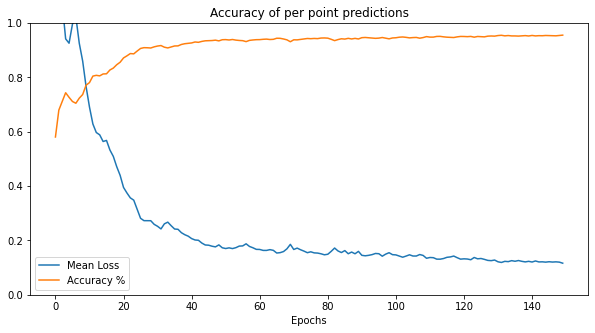

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,5))
plt.plot(mean_loss, label='Mean Loss')
plt.plot(accuracy, label='Accuracy %')
plt.legend()
plt.ylim((0,1))
plt.title('Accuracy of per point predictions')
plt.xlabel('Epochs');

# 5. Validation

## 5.1 Load Dataset

In [51]:
sequence_path = 'mini_dataset/2013_05_28_drive_0000_006154_006400_mini_validation.npy'
cam2world_path = 'mini_dataset/cam0_to_world.txt'
frame_start = 5660
frame_end = 5790
box_size = [15,15,20]

val_dataset = KITTI360Dataset(sequence_path, cam2world_path, num_points=num_points,
                              box_size=box_size, frame_step=frame_step, frame_start=frame_start, 
                              frame_end=frame_end, estimate_normals=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                                         num_workers=num_workers, pin_memory=True)

Total of 33 frames in dataset.


## 5.2 Define Validation function

In [52]:
def validation(classifier, val_loader, file_name_end, load_checkpoint=None):
    print("Number of validation samples: ", len(val_loader))

    if load_checkpoint:
        checkpoint = torch.load(load_checkpoint)
        classifier.load_state_dict(checkpoint['model_state_dict'])

    mean_loss = []
    accuracy_list = []
    class_num_points = {x:0 for x in range(num_classes)}
    true_positive = {x:0 for x in range(num_classes)}
    false_positive = {x:0 for x in range(num_classes)}
    false_negative = {x:0 for x in range(num_classes)}
    class_accuracy = {x:0 for x in range(num_classes)}
    class_mIoU = {x:0 for x in range(num_classes)}

    print('---------- VALIDATION ----------')
    
    num_batches = len(val_loader)
    total_correct = 0
    total_points = 0
    loss_sum = 0
    with torch.no_grad():
        classifier.eval()
        for i, data in notebook.tqdm(enumerate(val_loader), total=len(val_loader)):
            points, target = data
            points, target = points.float().to(device), target.long().to(device)
            scores, trans_feat = classifier(points)
            scores = scores.contiguous().view(-1, num_classes)
            batch_label = target.view(-1, 1)[:, 0].cpu().data.numpy()
            target = target.view(-1, 1)[:, 0]
            loss = F.nll_loss(scores, target)
            predictions = scores.cpu().data.max(-1)[1].numpy()
            correct = np.sum(predictions == batch_label)
            total_correct += correct
            total_points += (batch_size * num_points)
            loss_sum += loss.item()
            
            for j in range(num_classes):
                class_num_points[j] += (target[target==j]).shape[0]
                true_positive[j] += np.sum(batch_label[batch_label==j] == predictions[batch_label==j])
                false_positive[j] += np.sum(batch_label[predictions==j] != predictions[predictions==j])
                false_negative[j] += np.sum(batch_label[batch_label==j] != predictions[batch_label==j])

    for i in range(num_classes):
        if class_num_points[i] != 0:
            class_accuracy[i] = true_positive[i]/class_num_points[i]
            class_mIoU[i] = true_positive[i]/(true_positive[i] + false_positive[i] + false_negative[i])

    accuracy = total_correct / total_points
    mean_loss.append(loss_sum / num_batches)
    accuracy_list.append(accuracy)
    print('Mean loss: %f' % (loss_sum / num_batches))
    print('Accuracy: %f' % (100*accuracy))

    #np.save('val_mean_loss' + file_name_end, mean_loss)
    #np.save('val_accuracy' + file_name_end, accuracy_list)
    #np.save('val_class_accuracy' + file_name_end, class_accuracy)
    #np.save('val_class_mIoU' + file_name_end, class_mIoU)
    return mean_loss, accuracy_list, class_accuracy, class_mIoU

## 5.3 Start Validation

In [53]:
val_mean_loss, val_accuracy, val_class_accuracy, val_class_mIoU = validation(classifier, val_loader, file_name_end, save_path)

Number of validation samples:  33
---------- VALIDATION ----------



Mean loss: 1.753065
Accuracy: 67.844460


## 5.4 Save Validation Class Accuracy and mIoU

In [54]:
import csv

with open('results/val_class_accuracy' + file_name_end + '.csv', 'w', newline='') as csvfile:
    fieldnames = ['id', 'accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for i in range(num_classes):
        writer.writerow({'id':i, 'accuracy':val_class_accuracy[i]})

with open('results/val_class_mIoU' + file_name_end + '.csv', 'w', newline='') as csvfile:
    fieldnames = ['id', 'mIoU']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for i in range(num_classes):
        writer.writerow({'id':i, 'mIoU':val_class_mIoU[i]})

In [33]:
save_path

'checkpoints/Test_Point_Cloud_Project_9C_4L_4096.pth'

# 6. Make Predictions

In [ ]:
for i, data in enumerate(val_loader):
    points, target = data
    points, target = points.float().to(device), target.long().to(device)
    classifier.eval()
    scores, trans_feat = classifier(points)
    scores = scores.contiguous().view(-1, num_classes)
    batch_label = target.view(-1, 1)[:, 0].cpu().data.numpy()
    predictions = scores.cpu().data.max(-1)[1].numpy()
    break

In [ ]:
np.save('predictions', predictions)
np.save('points', points.detach().cpu().numpy())
np.save('target', target.detach().cpu().numpy())

# 7. Generating Point Clouds with VAE

## 7.1 Define Network and Load Weights

In [ ]:
#checkpoint = torch.load('checkpoints/VAE4096.pth', map_location=torch.device('cpu'))
checkpoint = torch.load('checkpoints/VAE4096.pth')
classifier.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
N = 4
classifier.eval()

# Sample z~p(z)
z = torch.randn((N, classifier.enc.zdim)).to(device)

# Decode
sample = classifier.dec(z).detach().cpu().numpy()

np.save('reconstruction-23', sample)